# Определение возраста покупателей

## Исследовательский анализ данных

Проект "Определение возраста покупателей"
Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы: Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы; Контролировать добросовестность кассиров при продаже алкоголя. Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

In [ ]:
# Загрузка датасет с метками
labels = pd.read_csv('/datasets/faces/labels.csv')

In [ ]:
# 1. Анализ размера выборки
display ("Размер выборки:")
display(f"Общее количество изображений: {len(labels)}")
display("Основная информация о данных:")
display(labels.info())
display("Первые 5 строк меток:")
display(labels.head())

'Размер выборки:'

'Общее количество изображений: 7591'

'Основная информация о данных:'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


None

'Первые 5 строк меток:'

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


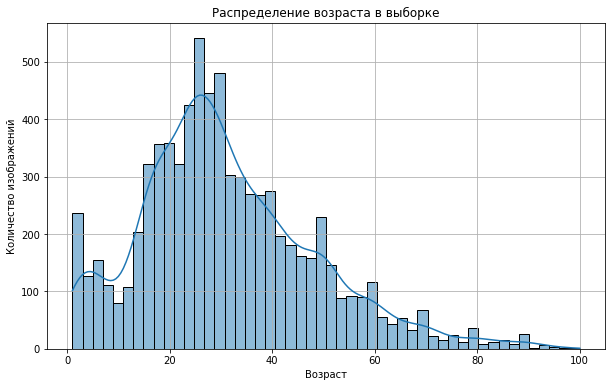

In [ ]:
# 2. График распределения возраста
plt.figure(figsize=(10, 6))
sns.histplot(data=labels, x='real_age', bins=50, kde=True)
plt.title('Распределение возраста в выборке')
plt.xlabel('Возраст')
plt.ylabel('Количество изображений')
plt.grid(True)
plt.show()

Found 7591 validated image filenames.


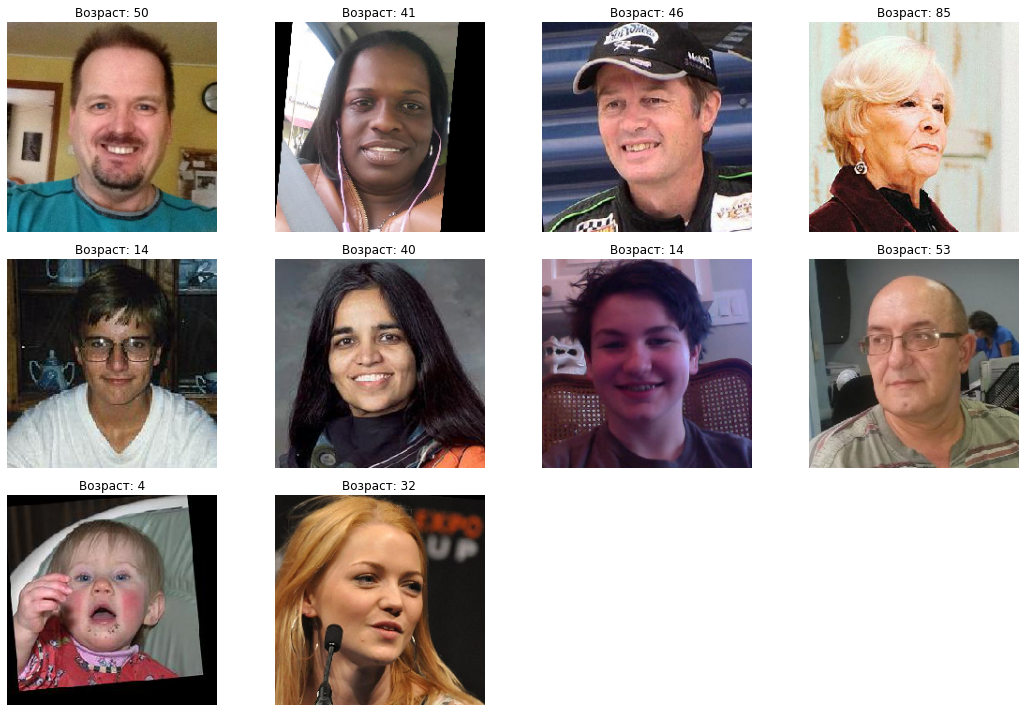

In [ ]:
# 3. Визуализация фотографий
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
    dataframe=labels,
    directory='/datasets/faces/final_files/',
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    seed=12345
)

# Получение одного батча изображений
images, ages = next(train_gen_flow)

# Визуализация первых 10 изображений
plt.figure(figsize=(15, 10))
for i in range(10):
    plt.subplot(3, 4, i + 1)
    plt.imshow(images[i])
    plt.title(f'Возраст: {int(ages[i])}')
    plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# 4. Статистический анализ возраста
display("\nСтатистика по возрасту:")
display (labels['real_age'].describe())

'\nСтатистика по возрасту:'

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

Выводы для обучения модели:   
- Размер выборки: 7591 изображений. Выборка немаленькая, изображений для обучения модели должно быть достаточно.  

- Распределение возраста: Несбалансированное распределение. Медианный возраст 29 лет, средний 31.  Максимальный - 100, минимальный 1год. Может потребоваться внимание к редким возрастным группам.

- Качество изображений: изображения разнообразны по условиям съёмки, качество хорошее.  


## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        horizontal_flip=True,
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        rescale=1./255)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,  
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow

def create_model(input_shape):
    backbone = ResNet50(weights='imagenet',
                       input_shape=input_shape,
                       include_top=False)

    for layer in backbone.layers[-10:]:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = True

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='relu'))  

    optimizer = Adam(learning_rate=0.0001)  
    model.compile(optimizer=optimizer,
                 loss='mse',
                 metrics=['mae'])

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=30,
                steps_per_epoch=None, validation_steps=None):

    callbacks = [
        ReduceLROnPlateau(monitor='val_mae', patience=3, factor=0.5, min_lr=1e-6)
    ]

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              callbacks=callbacks,
              verbose=2)

    return model

```

```178/178 - 102s - loss: 827.7217 - mae: 24.7881 - val_loss: 1158.1847 - val_mae: 29.6162
Epoch 2/30
178/178 - 93s - loss: 594.7707 - mae: 20.5552 - val_loss: 1152.7329 - val_mae: 29.5365
Epoch 3/30
178/178 - 95s - loss: 513.7840 - mae: 18.7519 - val_loss: 474.3579 - val_mae: 17.0409
Epoch 4/30
178/178 - 93s - loss: 476.8201 - mae: 17.5574 - val_loss: 361.4430 - val_mae: 14.9694
Epoch 5/30
178/178 - 93s - loss: 387.4191 - mae: 15.8003 - val_loss: 466.7353 - val_mae: 17.9273
Epoch 6/30
178/178 - 94s - loss: 348.7420 - mae: 14.6051 - val_loss: 291.8278 - val_mae: 13.3293
Epoch 7/30
178/178 - 93s - loss: 349.2212 - mae: 14.5219 - val_loss: 574.3245 - val_mae: 20.5116
Epoch 8/30
178/178 - 93s - loss: 275.5463 - mae: 12.7310 - val_loss: 452.7126 - val_mae: 16.7693
Epoch 9/30
178/178 - 93s - loss: 272.8501 - mae: 12.7043 - val_loss: 365.1836 - val_mae: 15.0552
Epoch 10/30
178/178 - 93s - loss: 231.4128 - mae: 11.5861 - val_loss: 141.3819 - val_mae: 9.0777
Epoch 11/30
178/178 - 93s - loss: 206.6560 - mae: 10.9720 - val_loss: 234.3064 - val_mae: 11.8357
Epoch 12/30
178/178 - 91s - loss: 202.6257 - mae: 10.8353 - val_loss: 119.9612 - val_mae: 8.1436
Epoch 13/30
178/178 - 91s - loss: 181.8294 - mae: 10.2181 - val_loss: 204.8336 - val_mae: 11.3096
Epoch 14/30
178/178 - 92s - loss: 183.4610 - mae: 10.2127 - val_loss: 293.1028 - val_mae: 13.4615
Epoch 15/30
178/178 - 91s - loss: 178.0039 - mae: 10.0640 - val_loss: 184.5327 - val_mae: 9.5843
Epoch 16/30
178/178 - 91s - loss: 169.0912 - mae: 9.6457 - val_loss: 163.9084 - val_mae: 9.2472
Epoch 17/30
178/178 - 91s - loss: 151.3636 - mae: 9.1740 - val_loss: 135.7198 - val_mae: 8.5818
Epoch 18/30
178/178 - 91s - loss: 140.4376 - mae: 8.9100 - val_loss: 102.5795 - val_mae: 7.6200
Epoch 19/30
178/178 - 91s - loss: 137.1008 - mae: 8.8512 - val_loss: 129.5214 - val_mae: 8.3647
Epoch 20/30
178/178 - 92s - loss: 139.3098 - mae: 8.9481 - val_loss: 112.7958 - val_mae: 7.8909
Epoch 21/30
178/178 - 91s - loss: 127.9848 - mae: 8.5512 - val_loss: 151.8749 - val_mae: 9.0043
Epoch 22/30
178/178 - 92s - loss: 123.3647 - mae: 8.2934 - val_loss: 137.2317 - val_mae: 8.5111
Epoch 23/30
178/178 - 91s - loss: 119.7187 - mae: 8.2263 - val_loss: 115.4609 - val_mae: 7.8452
Epoch 24/30
178/178 - 91s - loss: 118.3350 - mae: 8.1352 - val_loss: 120.8684 - val_mae: 8.2181
Epoch 25/30
178/178 - 93s - loss: 108.5831 - mae: 7.8627 - val_loss: 136.9101 - val_mae: 8.9697
Epoch 26/30
178/178 - 93s - loss: 106.0245 - mae: 7.8047 - val_loss: 113.8018 - val_mae: 7.9760
Epoch 27/30
178/178 - 94s - loss: 109.3395 - mae: 7.8591 - val_loss: 111.4165 - val_mae: 7.8431
Epoch 28/30
178/178 - 94s - loss: 106.0055 - mae: 7.7268 - val_loss: 113.2488 - val_mae: 7.9248
Epoch 29/30
178/178 - 94s - loss: 102.6749 - mae: 7.6789 - val_loss: 115.8610 - val_mae: 8.0249
Epoch 30/30
178/178 - 93s - loss: 100.9694 - mae: 7.5912 - val_loss: 109.2984 - val_mae: 7.7909
```

## Анализ обученной модели

Модель показала приемлемый уровень качества < 8  благодаря:

**Аугментации данных:**

- Добавлены rotation_range, width_shift_range, height_shift_range, zoom_range

- batch_size = 32 для более стабильного обучения

**Архитектура модели:**

- Transfer Learning (ResNet50) показал хорошую эффективность   
- Разморожены последние 10 слоев ResNet50 (кроме BatchNormalization)
- Добавлены BatchNormalization и Dropout слои для регуляризации и контроля переобучения
- Добавлен дополнительный Dense(256) слой  
- Уменьшен learning rate до 0.0001  

**Обучение модели:**

- Кол-во эпох до 30  
- Добавлен ReduceLROnPlateau callback для адаптивного обучения  
- Используется мониторинг val_mae для callback'ов  

**Выводы:**  
Лучший mae=7.62 на 18-ой эпохе.  
  
MAE тренировочный показывает снижение от 20 до 7.25, MAE валидационный в пределах 29 и 7.62. Возможно, что переобучения нет, т.к. минимальные mae на двух выборках схожи 7.25 и 7.62.
На Epoch 10 наблюдается резкое улучшение (val_mae=9.08 → 8.14 на Epoch 12).   
Архитектура демонстрирует хороший баланс между обучением и обобщением, о чем свидетельствует минимальный разрыв между train и val ошибками.   
Модель сохраняет стабильность после 15-й эпохи.    


В целом модель может применяться для решения задач бизнеса для определения возраста и рекомендуется к внедрению в Сетевой супермаркет «Хлеб-Соль» .  
  
